# 凸性
:label:`sec_convexity`

*凸性*（convexity）在优化算法的设计中起到至关重要的作用，
这主要是由于在这种情况下对算法进行分析和测试要容易。
换言之，如果算法在凸性条件设定下的效果很差，
那通常我们很难在其他条件下看到好的结果。
此外，即使深度学习中的优化问题通常是非凸的，
它们也经常在局部极小值附近表现出一些凸性。
这可能会产生一些像 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`这样比较有意思的新优化变体。


In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
# from d2l import torch as d2l

## 定义

在进行凸分析之前，我们需要定义*凸集*（convex sets）和*凸函数*（convex functions）。

### 凸集

*凸集*（convex set）是凸性的基础。
简单地说，如果对于任何$a, b \in \mathcal{X}$，连接$a$和$b$的线段也位于$\mathcal{X}$中，则向量空间中的一个集合$\mathcal{X}$是*凸*（convex）的。
在数学术语上，这意味着对于所有$\lambda \in [0, 1]$，我们得到

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ 当 } a, b \in \mathcal{X}.$$

这听起来有点抽象，那我们来看一下 :numref:`fig_pacman`里的例子。
第一组存在不包含在集合内部的线段，所以该集合是非凸的，而另外两组则没有这样的问题。

![第一组是非凸的，另外两组是凸的。](../img/pacman.svg)
:label:`fig_pacman`

接下来来看一下交集 :numref:`fig_convex_intersect`。
假设$\mathcal{X}$和$\mathcal{Y}$是凸集，那么$\mathcal {X} \cap \mathcal{Y}$也是凸集的。
现在考虑任意$a, b \in \mathcal{X} \cap \mathcal{Y}$，
因为$\mathcal{X}$和$\mathcal{Y}$是凸集，
所以连接$a$和$b$的线段包含在$\mathcal{X}$和$\mathcal{Y}$中。
鉴于此，它们也需要包含在$\mathcal {X} \cap \mathcal{Y}$中，从而证明我们的定理。

![两个凸集的交集是凸的。](../img/convex-intersect.svg)
:label:`fig_convex_intersect`

我们可以毫不费力地进一步得到这样的结果：
给定凸集$\mathcal{X}_i$，它们的交集$\cap_{i} \mathcal{X}_i$是凸的。
但是反向是不正确的，考虑两个不相交的集合$\mathcal{X} \cap \mathcal{Y} = \emptyset$，
取$a \in \mathcal{X}$和$b \in \mathcal{Y}$。
因为我们假设$\mathcal{X} \cap \mathcal{Y} = \emptyset$，
在 :numref:`fig_nonconvex`中连接$a$和$b$的线段需要包含一部分既不在$\mathcal{X}$也不在$\mathcal{Y}$中。
因此线段也不在$\mathcal{X} \cup \mathcal{Y}$中，因此证明了凸集的并集不一定是凸的，即*非凸*（nonconvex）的。

![两个凸集的并集不一定是凸的。](../img/nonconvex.svg)
:label:`fig_nonconvex`

通常，深度学习中的问题是在凸集上定义的。
例如，$\mathbb{R}^d$，即实数的$d$-维向量的集合是凸集（毕竟$\mathbb{R}^d$中任意两点之间的线存在$\mathbb{R}^d$）中。
在某些情况下，我们使用有界长度的变量，例如球的半径定义为$\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ 且 } \| \mathbf{x} \| \leq r\}$。

### 凸函数

现在我们有了凸集，我们可以引入*凸函数*（convex function）$f$。
给定一个凸集$\mathcal{X}$，如果对于所有$x, x' \in \mathcal{X}$和所有$\lambda \in [0, 1]$，函数$f: \mathcal{X} \to \mathbb{R}$是凸的，我们可以得到

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

为了说明这一点，让我们绘制一些函数并检查哪些函数满足要求。
下面我们定义一些函数，包括凸函数和非凸函数。


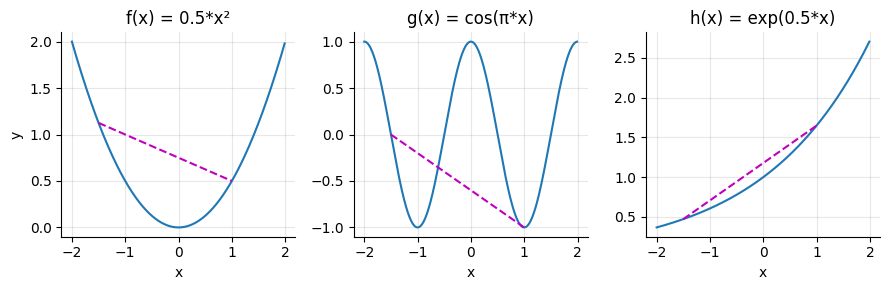

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 定义函数
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

# 创建数据
x = torch.arange(-2, 2, 0.01)
segment = torch.tensor([-1.5, 1])

# 设置显示选项
plt.rcParams['figure.figsize'] = (9, 3)
plt.rcParams['savefig.format'] = 'svg'

# 创建图形和子图
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# 定义绘图函数
def plot_data(x_data, y_data, ax):
    if isinstance(x_data, list):
        # 绘制多条线
        for i in range(len(x_data)):
            x_vals = x_data[i].numpy() if torch.is_tensor(x_data[i]) else x_data[i]
            y_vals = y_data[i].numpy() if torch.is_tensor(y_data[i]) else y_data[i]
            ax.plot(x_vals, y_vals)
    else:
        x_vals = x_data.numpy() if torch.is_tensor(x_data) else x_data
        y_vals = y_data.numpy() if torch.is_tensor(y_data) else y_data
        ax.plot(x_vals, y_vals)

# 在每个子图上绘制数据
functions = [f, g, h]
function_names = ['f(x) = 0.5*x²', 'g(x) = cos(π*x)', 'h(x) = exp(0.5*x)']

for i, (ax, func, name) in enumerate(zip(axes, functions, function_names)):
    # 计算函数值
    y_x = func(x)
    y_segment = func(segment)
    
    # 绘制曲线
    ax.plot(x.numpy(), y_x.numpy(), linewidth=1.5, color='#1f77b4')
    # 绘制线段
    ax.plot(segment.numpy(), y_segment.numpy(), '--', linewidth=1.5, color='#bf00bf')
    
    # 设置标题和网格
    ax.set_title(name)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    
    # 设置坐标轴
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 添加y标签（仅第一个子图）
    if i == 0:
        ax.set_ylabel('y')

# 调整布局
plt.tight_layout()
plt.show()

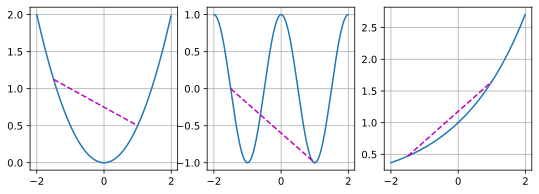

In [2]:
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

不出所料，余弦函数为非凸的，而抛物线函数和指数函数为凸的。
请注意，为使该条件有意义，$\mathcal{X}$是凸集的要求是必要的。
否则可能无法很好地界定$f(\lambda x + (1-\lambda) x')$的结果。

### 詹森不等式

给定一个凸函数$f$，最有用的数学工具之一就是*詹森不等式*（Jensen's inequality）。
它是凸性定义的一种推广：

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right) \text{ and } E_X[f(X)] \geq f\left(E_X[X]\right),$$
:eqlabel:`eq_jensens-inequality`

其中$\alpha_i$是满足$\sum_i \alpha_i = 1$的非负实数，$X$是随机变量。
换句话说，凸函数的期望不小于期望的凸函数，其中后者通常是一个更简单的表达式。
为了证明第一个不等式，我们多次将凸性的定义应用于一次求和中的一项。

詹森不等式的一个常见应用：用一个较简单的表达式约束一个较复杂的表达式。
例如，它可以应用于部分观察到的随机变量的对数似然。
具体地说，由于$\int P(Y) P(X \mid Y) dY = P(X)$，所以

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

这里，$Y$是典型的未观察到的随机变量，$P(Y)$是它可能如何分布的最佳猜测，$P(X)$是将$Y$积分后的分布。
例如，在聚类中$Y$可能是簇标签，而在应用簇标签时，$P(X \mid Y)$是生成模型。

## 性质

下面我们来看一下凸函数一些有趣的性质。

### 局部极小值是全局极小值

首先凸函数的局部极小值也是全局极小值。
下面我们用反证法给出证明。

假设$x^{\ast} \in \mathcal{X}$是一个局部最小值，则存在一个很小的正值$p$，使得当$x \in \mathcal{X}$满足$0 < |x - x^{\ast}| \leq p$时，有$f(x^{\ast}) < f(x)$。

现在假设局部极小值$x^{\ast}$不是$f$的全局极小值：存在$x' \in \mathcal{X}$使得$f(x') < f(x^{\ast})$。
则存在
$\lambda \in [0, 1)$，比如$\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$，使得
$0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$。

然而，根据凸性的性质，有

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}), \\
\end{aligned}$$

这与$x^{\ast}$是局部最小值相矛盾。
因此，不存在$x' \in \mathcal{X}$满足$f(x') < f(x^{\ast})$。
综上所述，局部最小值$x^{\ast}$也是全局最小值。

例如，对于凸函数$f(x) = (x-1)^2$，有一个局部最小值$x=1$，它也是全局最小值。


C:\Users\11499\AppData\Local\Temp\ipykernel_39592\778962692.py:37: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\11499\AppData\Local\Temp\ipykernel_39592\778962692.py:37: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


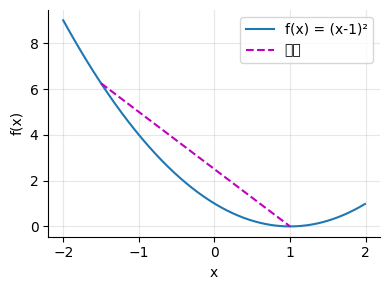

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 定义函数
f = lambda x: (x - 1) ** 2

# 创建数据
x = torch.arange(-2, 2, 0.01)
segment = torch.tensor([-1.5, 1])

# 设置图形大小
plt.figure(figsize=(4, 3))

# 计算函数值
y_x = f(x)
y_segment = f(segment)

# 绘制曲线
plt.plot(x.numpy(), y_x.numpy(), linewidth=1.5, color='#1f77b4', label='f(x) = (x-1)²')
# 绘制线段
plt.plot(segment.numpy(), y_segment.numpy(), '--', linewidth=1.5, color='#bf00bf', label='线段')

# 设置标签和网格
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True, alpha=0.3)

# 设置坐标轴
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 添加图例
plt.legend()

# 调整布局并显示
plt.tight_layout()
plt.show()

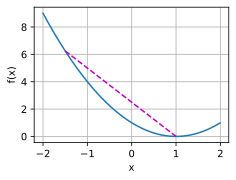

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

凸函数的局部极小值同时也是全局极小值这一性质是很方便的。
这意味着如果我们最小化函数，我们就不会“卡住”。
但是请注意，这并不意味着不能有多个全局最小值，或者可能不存在一个全局最小值。
例如，函数$f(x) = \mathrm{max}(|x|-1, 0)$在$[-1,1]$区间上都是最小值。
相反，函数$f(x) = \exp(x)$在$\mathbb{R}$上没有取得最小值。对于$x \to -\infty$，它趋近于$0$，但是没有$f(x) = 0$的$x$。

### 凸函数的下水平集是凸的

我们可以方便地通过凸函数的*下水平集*（below sets）定义凸集。
具体来说，给定一个定义在凸集$\mathcal{X}$上的凸函数$f$，其任意一个下水平集

$$\mathcal{S}_b := \{x | x \in \mathcal{X} \text{ and } f(x) \leq b\}$$

是凸的。

让我们快速证明一下。
对于任何$x, x' \in \mathcal{S}_b$，我们需要证明：当$\lambda \in [0, 1]$时，$\lambda x + (1-\lambda) x' \in \mathcal{S}_b$。
因为$f(x) \leq b$且$f(x') \leq b$，所以

$$f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b.$$

### 凸性和二阶导数

当一个函数的二阶导数$f: \mathbb{R}^n \rightarrow \mathbb{R}$存在时，我们很容易检查这个函数的凸性。
我们需要做的就是检查$\nabla^2f \succeq 0$，
即对于所有$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$.
例如，函数$f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$是凸的，因为$\nabla^2 f = \mathbf{1}$，即其导数是单位矩阵。

更正式地讲，$f$为凸函数，当且仅当任意二次可微一维函数$f: \mathbb{R}^n \rightarrow \mathbb{R}$是凸的。
对于任意二次可微多维函数$f: \mathbb{R}^{n} \rightarrow \mathbb{R}$，
它是凸的当且仅当它的Hessian$\nabla^2f\succeq 0$。

首先，我们来证明一下一维情况。
为了证明凸函数的$f''(x) \geq 0$，我们使用：

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

因为二阶导数是由有限差分的极限给出的，所以遵循

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$$

为了证明$f'' \geq 0$可以推导$f$是凸的，
我们使用这样一个事实：$f'' \geq 0$意味着$f'$是一个单调的非递减函数。
假设$a < x < b$是$\mathbb{R}$中的三个点，
其中，$x = (1-\lambda)a + \lambda b$且$\lambda \in (0, 1)$.
根据中值定理，存在$\alpha \in [a, x]$，$\beta \in [x, b]$，使得
$$f'(\alpha) = \frac{f(x) - f(a)}{x-a} \text{ 且 } f'(\beta) = \frac{f(b) - f(x)}{b-x}.$$

通过单调性$f'(\beta) \geq f'(\alpha)$，因此

$$\frac{x-a}{b-a}f(b) + \frac{b-x}{b-a}f(a) \geq f(x).$$

由于$x = (1-\lambda)a + \lambda b$，所以

$$\lambda f(b) + (1-\lambda)f(a) \geq f((1-\lambda)a + \lambda b),$$

从而证明了凸性。

第二，我们需要一个引理证明多维情况： $f: \mathbb{R}^n \rightarrow \mathbb{R}$ 是凸的当且仅当对于所有$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$

$$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z) \mathbf{y}) \text{，其中 } z \in [0,1]$$

是凸的。

为了证明$f$的凸性意味着$g$是凸的，
我们可以证明，对于所有的$a，b，\lambda \in[0，1]$（这样有$0 \leq \lambda a + (1-\lambda) b \leq 1$），

$$\begin{aligned} &g(\lambda a + (1-\lambda) b)\ ={}&f\left(\left(\lambda a + (1-\lambda) b\right)\mathbf{x} + \left(1-\lambda a - (1-\lambda) b\right)\mathbf{y} \right)\ ={}&f\left(\lambda \left(a \mathbf{x} + (1-a) \mathbf{y}\right) + (1-\lambda) \left(b \mathbf{x} + (1-b) \mathbf{y}\right) \right)\ \leq{}&\lambda f\left(a \mathbf{x} + (1-a) \mathbf{y}\right) + (1-\lambda) f\left(b \mathbf{x} + (1-b) \mathbf{y}\right) \ ={}&\lambda g(a) + (1-\lambda) g(b). \end{aligned}$$


为了证明这一点，我们可以证明对
$[0，1]$中所有的$\lambda$：

$$\begin{aligned} &f(\lambda \mathbf{x} + (1-\lambda) \mathbf{y})\\
=&g(\lambda \cdot 1 + (1-\lambda) \cdot 0)\\
\leq& \lambda g(1)  + (1-\lambda) g(0) \\
=& \lambda f(\mathbf{x}) + (1-\lambda) f(\mathbf{y}).
\end{aligned}$$

最后，利用上面的引理和一维情况的结果，我们可以证明多维情况：
多维函数$f:\mathbb{R}^n\rightarrow\mathbb{R}$是凸函数，当且仅当$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y})$是凸的，这里$z \in [0,1]$，$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$。
根据一维情况，
此条成立的条件为，当且仅当对于所有$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$，
$g'' = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{y}) \geq 0$（$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2f$）。
这相当于根据半正定矩阵的定义，$\mathbf{H} \succeq 0$。

## 约束

凸优化的一个很好的特性是能够让我们有效地处理*约束*（constraints）。
即它使我们能够解决以下形式的*约束优化*（constrained optimization）问题：

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, N\}.
\end{aligned}$$

这里$f$是目标函数，$c_i$是约束函数。
例如第一个约束$c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$，则参数$\mathbf{x}$被限制为单位球。
如果第二个约束$c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$，那么这对应于半空间上所有的$\mathbf{x}$。
同时满足这两个约束等于选择一个球的切片作为约束集。

### 拉格朗日函数

通常，求解一个有约束的优化问题是困难的，解决这个问题的一种方法来自物理中相当简单的直觉。
想象一个球在一个盒子里，球会滚到最低的地方，重力将与盒子两侧对球施加的力平衡。
简而言之，目标函数（即重力）的梯度将被约束函数的梯度所抵消（由于墙壁的“推回”作用，需要保持在盒子内）。
请注意，任何不起作用的约束（即球不接触壁）都将无法对球施加任何力。

这里我们简略拉格朗日函数$L$的推导，上述推理可以通过以下鞍点优化问题来表示：

$$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

这里的变量$\alpha_i$（$i=1,\ldots,n$）是所谓的*拉格朗日乘数*（Lagrange multipliers），它确保约束被正确地执行。
选择它们的大小足以确保所有$i$的$c_i(\mathbf{x}) \leq 0$。
例如，对于$c_i(\mathbf{x}) < 0$中任意$\mathbf{x}$，我们最终会选择$\alpha_i = 0$。
此外，这是一个*鞍点*（saddlepoint）优化问题。
在这个问题中，我们想要使$L$相对于$\alpha_i$*最大化*（maximize），同时使它相对于$\mathbf{x}$*最小化*（minimize）。
有大量的文献解释如何得出函数$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n)$。
我们这里只需要知道$L$的鞍点是原始约束优化问题的最优解就足够了。

### 惩罚

一种至少近似地满足约束优化问题的方法是采用拉格朗日函数$L$。除了满足$c_i(\mathbf{x}) \leq 0$之外，我们只需将$\alpha_i c_i(\mathbf{x})$添加到目标函数$f(x)$。
这样可以确保不会严重违反约束。

事实上，我们一直在使用这个技巧。
比如权重衰减 :numref:`sec_weight_decay`，在目标函数中加入$\frac{\lambda}{2} |\mathbf{w}|^2$，以确保$\mathbf{w}$不会增长太大。
使用约束优化的观点，我们可以看到，对于若干半径$r$，这将确保$|\mathbf{w}|^2 - r^2 \leq 0$。
通过调整$\lambda$的值，我们可以改变$\mathbf{w}$的大小。

通常，添加惩罚是确保近似满足约束的一种好方法。
在实践中，这被证明比精确的满意度更可靠。
此外，对于非凸问题，许多使精确方法在凸情况下的性质（例如，可求最优解）不再成立。

### 投影

满足约束条件的另一种策略是*投影*（projections）。
同样，我们之前也遇到过，例如在 :numref:`sec_rnn_scratch`中处理梯度截断时，我们通过

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/\|\mathbf{g}\|),$$

确保梯度的长度以$\theta$为界限。

这就是$\mathbf{g}$在半径为$\theta$的球上的*投影*（projection）。
更泛化地说，在凸集$\mathcal{X}$上的投影被定义为

$$\mathrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|.$$

它是$\mathcal{X}$中离$\mathbf{X}$最近的点。

![Convex Projections.](../img/projections.svg)
:label:`fig_projections`

投影的数学定义听起来可能有点抽象，为了解释得更清楚一些，请看 :numref:`fig_projections`。
图中有两个凸集，一个圆和一个菱形。
两个集合内的点（黄色）在投影期间保持不变。
两个集合（黑色）之外的点投影到集合中接近原始点（黑色）的点（红色）。
虽然对$L_2$的球面来说，方向保持不变，但一般情况下不需要这样。

凸投影的一个用途是计算稀疏权重向量。
在本例中，我们将权重向量投影到一个$L_1$的球上，
这是 :numref:`fig_projections`中菱形例子的一个广义版本。

## 小结

在深度学习的背景下，凸函数的主要目的是帮助我们详细了解优化算法。
我们由此得出梯度下降法和随机梯度下降法是如何相应推导出来的。

* 凸集的交点是凸的，并集不是。
* 根据詹森不等式，“一个多变量凸函数的总期望值”大于或等于“用每个变量的期望值计算这个函数的总值“。
* 一个二次可微函数是凸函数，当且仅当其Hessian（二阶导数矩阵）是半正定的。
* 凸约束可以通过拉格朗日函数来添加。在实践中，只需在目标函数中加上一个惩罚就可以了。
* 投影映射到凸集中最接近原始点的点。

## 练习 

1. 假设我们想要通过绘制集合内点之间的所有直线并检查这些直线是否包含来验证集合的凸性。i.证明只检查边界上的点是充分的。ii.证明只检查集合的顶点是充分的。

2. 用$p$-范数表示半径为$r$的球，证明$\mathcal{B}_p[r] := \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \|\mathbf{x}\|_p \leq r\}$，$\mathcal{B}_p[r]$对于所有$p \geq 1$是凸的。

3. 已知凸函数$f$和$g$表明$\mathrm{max}(f, g)$也是凸函数。证明$\mathrm{min}(f, g)$是非凸的。

4. 证明Softmax函数的规范化是凸的，即$f(x) = \log \sum_i \exp(x_i)$的凸性。

5. 证明线性子空间$\mathcal{X} = \{\mathbf{x} | \mathbf{W} \mathbf{x} = \mathbf{b}\}$是凸集。

6. 证明在线性子空间$\mathbf{b} = \mathbf{0}$的情况下，对于矩阵$\mathbf{M}$的投影$\mathrm {Proj} \mathcal{X}$可以写成$\mathbf{M} \mathbf{X}$。

7. 证明对于凸二次可微函数$f$，对于$\xi \in [0, \epsilon]$，我们可以写成$f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$。

8. 给定一个凸集$\mathcal{X}$和两个向量$\mathbf{x}$和$\mathbf{y}$证明了投影不会增加距离，即$\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_\mathcal{X}(\mathbf{x}) - \mathrm{Proj}_\mathcal{X}(\mathbf{y})\|$。


[Discussions](https://discuss.d2l.ai/t/3815)
